# 📊 Telegram Sentiment Analysis

Simple and powerful sentiment analysis with beautiful visualizations.

In [1]:
# =============================================================================
# CELL 1: Setup and Imports
# =============================================================================

import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from btc_sentiment.pipelines.ingest_pipeline import run_simple_analysis
from btc_sentiment.utils.analysis import load_and_prepare_data

# Modern beautiful styling
plt.style.use('default')  # Start with clean slate
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Custom color palette
COLORS = {
    'primary': '#2E86C1',
    'secondary': '#F39C12', 
    'positive': '#27AE60',
    'negative': '#E74C3C',
    'neutral': '#95A5A6',
    'accent': '#8E44AD',
    'background': '#F8F9FA'
}

# Global plot settings
plt.rcParams.update({
    'figure.figsize': (15, 10),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white'
})

# Set custom color palette
custom_palette = [COLORS['primary'], COLORS['secondary'], COLORS['positive'], 
                 COLORS['negative'], COLORS['accent'], COLORS['neutral']]
sns.set_palette(custom_palette)

print("🎨 Visualization setup complete!")
print("📊 Custom styling and colors loaded")

%matplotlib inline

🎨 Visualization setup complete!
📊 Custom styling and colors loaded


## 🚀 Run Analysis

Choose your analysis period and run sentiment analysis.

🎯 Running sentiment analysis for last 1460 days...
📅 Requested window: 2021-09-11 → 2025-09-09 (1460 days expected) • telegram rows: 1460
Saved 1460 records to data/processed/daily_sentiment_20250909_132027.parquet


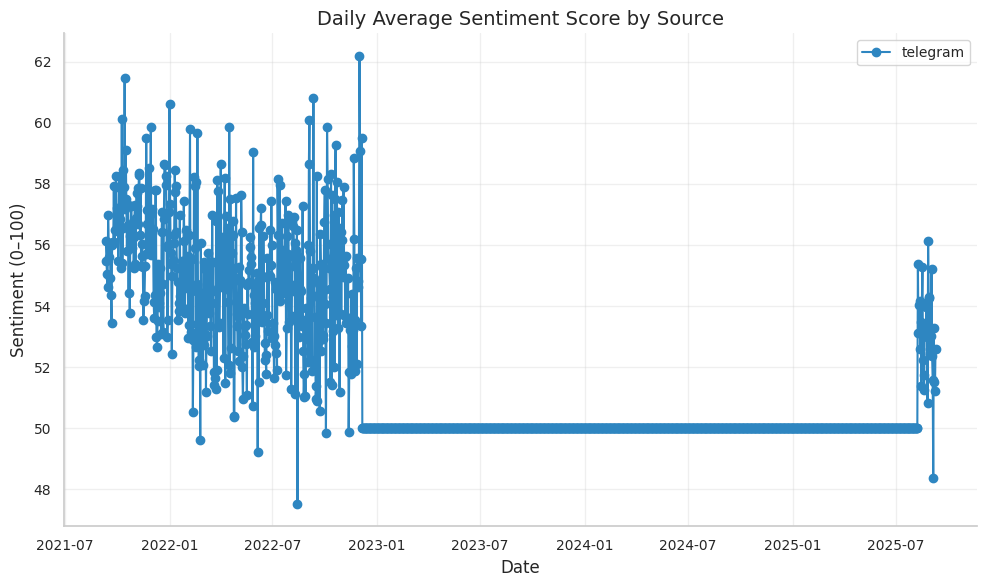

✅ Analysis complete! 1460 daily records generated.
✅ Loaded 1460 daily records
📅 Period: 2021-09-11 to 2025-09-09
💬 Total messages: 97,076


,date,source,avg_score,count,label
0,2021-09-11,telegram,56.140905,475,neutral
1,2021-09-12,telegram,55.490839,417,neutral
2,2021-09-13,telegram,55.046602,615,neutral
3,2021-09-14,telegram,54.622649,587,neutral
4,2021-09-15,telegram,56.969756,718,neutral
...,...,...,...,...,...
1455,2025-09-05,telegram,48.366311,206,neutral
1456,2025-09-06,telegram,53.279794,97,neutral
1457,2025-09-07,telegram,51.529724,181,neutral
1458,2025-09-08,telegram,51.229830,176,neutral


In [2]:
import nest_asyncio
nest_asyncio.apply()
# Set analysis period (change this to your desired timeframe)
DAYS_BACK = 1460  # Last 1 year

print(f'🎯 Running sentiment analysis for last {DAYS_BACK} days...')

# Run the analysis
daily_records = run_simple_analysis(days_back=DAYS_BACK)

# Load the results
df = load_and_prepare_data()

if df.empty:
    print('❌ No data available')
    print('💡 Check your Telegram credentials and group access')
else:
    print(f'✅ Loaded {len(df)} daily records')
    print(f'📅 Period: {df["date"].min().strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
    print(f'💬 Total messages: {df["count"].sum():,}')
    display(df)

## 📈 Beautiful Sentiment Dashboard

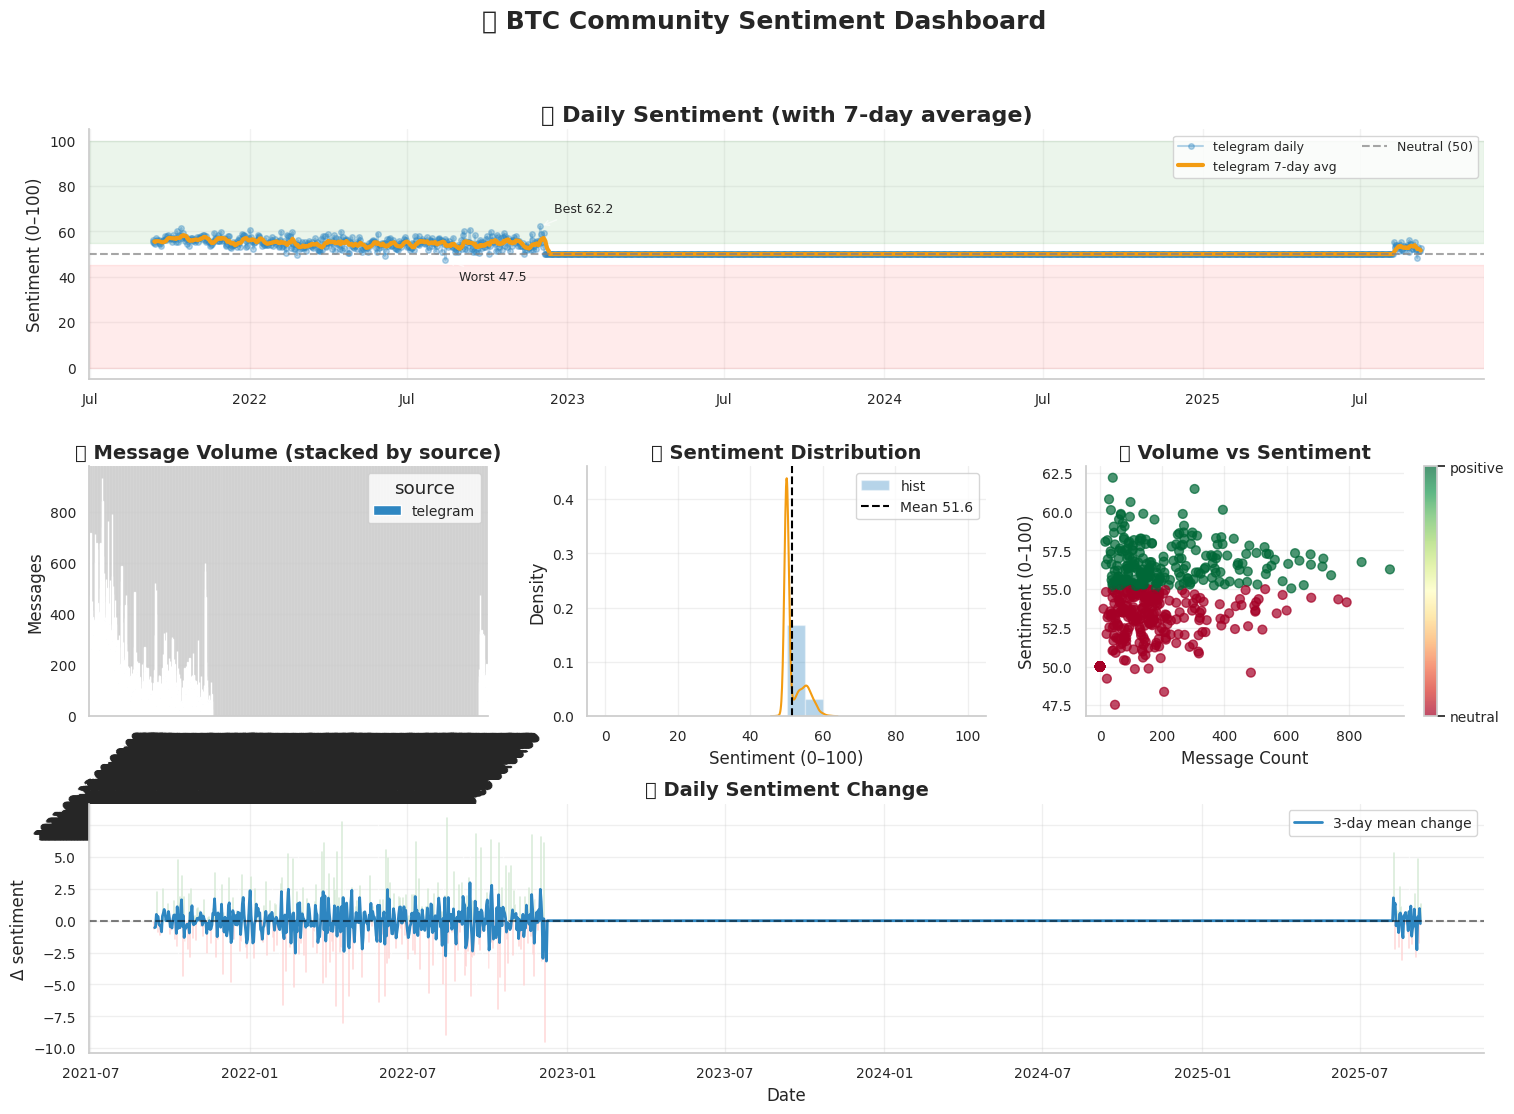

In [5]:
if not df.empty:
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    # tidy + sort
    df = df.sort_values('date').copy()
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    # 7-day rolling (per source if available)
    if 'source' in df.columns:
        df['avg_7d'] = df.groupby('source')['avg_score'].transform(lambda s: s.rolling(7, min_periods=3).mean())
    else:
        df['avg_7d'] = df['avg_score'].rolling(7, min_periods=3).mean()

    sources = df['source'].unique().tolist() if 'source' in df.columns else ['telegram']

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.25)

    # 1) Main sentiment timeline (with 7d avg + threshold zones)
    ax1 = fig.add_subplot(gs[0, :])
    for s in sources:
        d = df if s == 'telegram' and 'source' not in df.columns else df[df['source'] == s]
        ax1.plot(d['date'], d['avg_score'], marker='o', linewidth=1.5, markersize=4, alpha=0.35, label=f'{s} daily')
        if d['avg_7d'].notna().any():
            ax1.plot(d['date'], d['avg_7d'], linewidth=3, label=f'{s} 7-day avg')
    ax1.axhspan(0, 45, color='red', alpha=0.08)
    ax1.axhspan(55, 100, color='green', alpha=0.08)
    ax1.axhline(50, color='gray', linestyle='--', alpha=0.7, label='Neutral (50)')

    # annotate best/worst days
    best = df.loc[df['avg_score'].idxmax()]
    worst = df.loc[df['avg_score'].idxmin()]
    ax1.annotate(f"Best {best['avg_score']:.1f}", xy=(best['date'], best['avg_score']),
                 xytext=(10, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', alpha=0.6), fontsize=9)
    ax1.annotate(f"Worst {worst['avg_score']:.1f}", xy=(worst['date'], worst['avg_score']),
                 xytext=(10, -15), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', alpha=0.6), fontsize=9)

    ax1.set_title('📊 Daily Sentiment (with 7-day average)', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Sentiment (0–100)')
    ax1.legend(ncol=2, fontsize=9)
    ax1.grid(True, alpha=0.25)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

    # 2) Message volume (stacked by source if multiple)
    ax2 = fig.add_subplot(gs[1, 0])
    if 'source' in df.columns:
        pivot = df.pivot_table(index='date', columns='source', values='count', aggfunc='sum', fill_value=0)
        pivot.plot(kind='bar', stacked=True, ax=ax2, width=0.9)
    else:
        ax2.bar(df['date'], df['count'], alpha=0.8)
    ax2.set_title('💬 Message Volume (stacked by source)', fontweight='bold')
    ax2.set_ylabel('Messages')
    ax2.tick_params(axis='x', labelrotation=45)

    # 3) Sentiment distribution (hist + KDE if seaborn available)
    ax3 = fig.add_subplot(gs[1, 1])
    bins = np.linspace(0, 100, 21)
    ax3.hist(df['avg_score'], bins=bins, density=True, alpha=0.35, label='hist')
    try:
        import seaborn as sns
        sns.kdeplot(df['avg_score'], ax=ax3)
    except Exception:
        pass
    ax3.axvline(df['avg_score'].mean(), color='black', linestyle='--', linewidth=1.5,
                label=f"Mean {df['avg_score'].mean():.1f}")
    ax3.set_title('📈 Sentiment Distribution', fontweight='bold')
    ax3.set_xlabel('Sentiment (0–100)')
    ax3.legend()

    # 4) Volume vs Sentiment
    ax4 = fig.add_subplot(gs[1, 2])
    classes = np.where(df['avg_score'] >= 55, 2, np.where(df['avg_score'] <= 45, 0, 1))
    sc = ax4.scatter(df['count'], df['avg_score'], c=classes, cmap='RdYlGn', s=40, alpha=0.7)
    ax4.set_title('🔗 Volume vs Sentiment', fontweight='bold')
    ax4.set_xlabel('Message Count')
    ax4.set_ylabel('Sentiment (0–100)')
    cbar = plt.colorbar(sc, ax=ax4, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['negative', 'neutral', 'positive'])

    # 5) Daily sentiment change (+ 3-day mean)
    ax5 = fig.add_subplot(gs[2, :])
    change = df['avg_score'].diff()
    ax5.bar(df['date'], change.fillna(0), alpha=0.6, color=['green' if x > 0 else 'red' for x in change.fillna(0)])
    chg_ma = change.rolling(3, min_periods=2).mean()
    ax5.plot(df['date'], chg_ma, linewidth=2, label='3-day mean change')
    ax5.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('📊 Daily Sentiment Change', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Δ sentiment')
    ax5.set_xlabel('Date')
    ax5.legend()

    plt.suptitle('🎯 BTC Community Sentiment Dashboard', fontsize=18, fontweight='bold')
    plt.show()


## 📊 Key Insights & Statistics

In [6]:
if not df.empty:
    import numpy as np
    from itertools import groupby

    d = df.sort_values('date').copy()

    print('🎯 KEY INSIGHTS')
    print('=' * 60)

    avg = d['avg_score'].mean()
    std = d['avg_score'].std()
    tot_msgs = d['count'].sum()
    q25, q50, q75 = d['avg_score'].quantile([0.25, 0.5, 0.75]).round(2)

    print(f'📈 Average Sentiment: {avg:.2f}/100 (median {q50:.2f}; IQR {q25:.2f}–{q75:.2f})')
    if avg > 55:
        print('   🟢 BULLISH baseline')
    elif avg < 45:
        print('   🔴 BEARISH baseline')
    else:
        print('   🟡 NEUTRAL baseline')

    print(f'📊 Volatility (std): {std:.2f}')
    print(f'💬 Total Messages: {tot_msgs:,}  •  Daily avg: {tot_msgs/len(d):.0f}')

    best = d.loc[d['avg_score'].idxmax()]
    worst = d.loc[d['avg_score'].idxmin()]
    busy = d.loc[d['count'].idxmax()]
    print(f'🚀 Best Day:  {best["date"].strftime("%Y-%m-%d")}  (score {best["avg_score"]:.1f})')
    print(f'📉 Worst Day: {worst["date"].strftime("%Y-%m-%d")}  (score {worst["avg_score"]:.1f})')
    print(f'🔥 Busiest:   {busy["date"].strftime("%Y-%m-%d")}  ({busy["count"]} msgs)')

    # 14-day slope (pts/day)
    if len(d) >= 5:
        tail = d.tail(min(14, len(d)))
        x = np.arange(len(tail))
        m, b = np.polyfit(x, tail['avg_score'], 1)
        print(f'\n📉/📈 14-day slope: {m:+.2f} pts/day')
        if m > 0.2:
            print('   🚀 Trending up')
        elif m < -0.2:
            print('   📉 Trending down')
        else:
            print('   ➡️ Flat')

    # Longest positive/negative streaks by label
    labels = d['label'].tolist()
    def longest_streak(target):
        return max((sum(1 for _ in grp) for val, grp in groupby(labels) if val == target), default=0)
    print(f'\n🔁 Longest positive streak: {longest_streak("positive")} days')
    print(f'🔁 Longest negative streak: {longest_streak("negative")} days')

    # Correlation
    if d['count'].nunique() > 1:
        corr = d['count'].corr(d['avg_score'])
        print(f'\n🔗 Volume–Sentiment correlation: {corr:.3f}')
        if abs(corr) > 0.5:
            print('   📊 Strong relationship')
        elif abs(corr) > 0.2:
            print('   🧩 Mild relationship')
        else:
            print('   🫧 Weak/none')


🎯 KEY INSIGHTS
📈 Average Sentiment: 51.62/100 (median 50.00; IQR 50.00–53.29)
   🟡 NEUTRAL baseline
📊 Volatility (std): 2.64
💬 Total Messages: 97,076  •  Daily avg: 66
🚀 Best Day:  2022-12-01  (score 62.2)
📉 Worst Day: 2022-08-14  (score 47.5)
🔥 Busiest:   2021-10-28  (932 msgs)

📉/📈 14-day slope: -0.28 pts/day
   📉 Trending down

🔁 Longest positive streak: 3 days
🔁 Longest negative streak: 0 days

🔗 Volume–Sentiment correlation: 0.670
   📊 Strong relationship


## 🎨 Advanced Visualizations

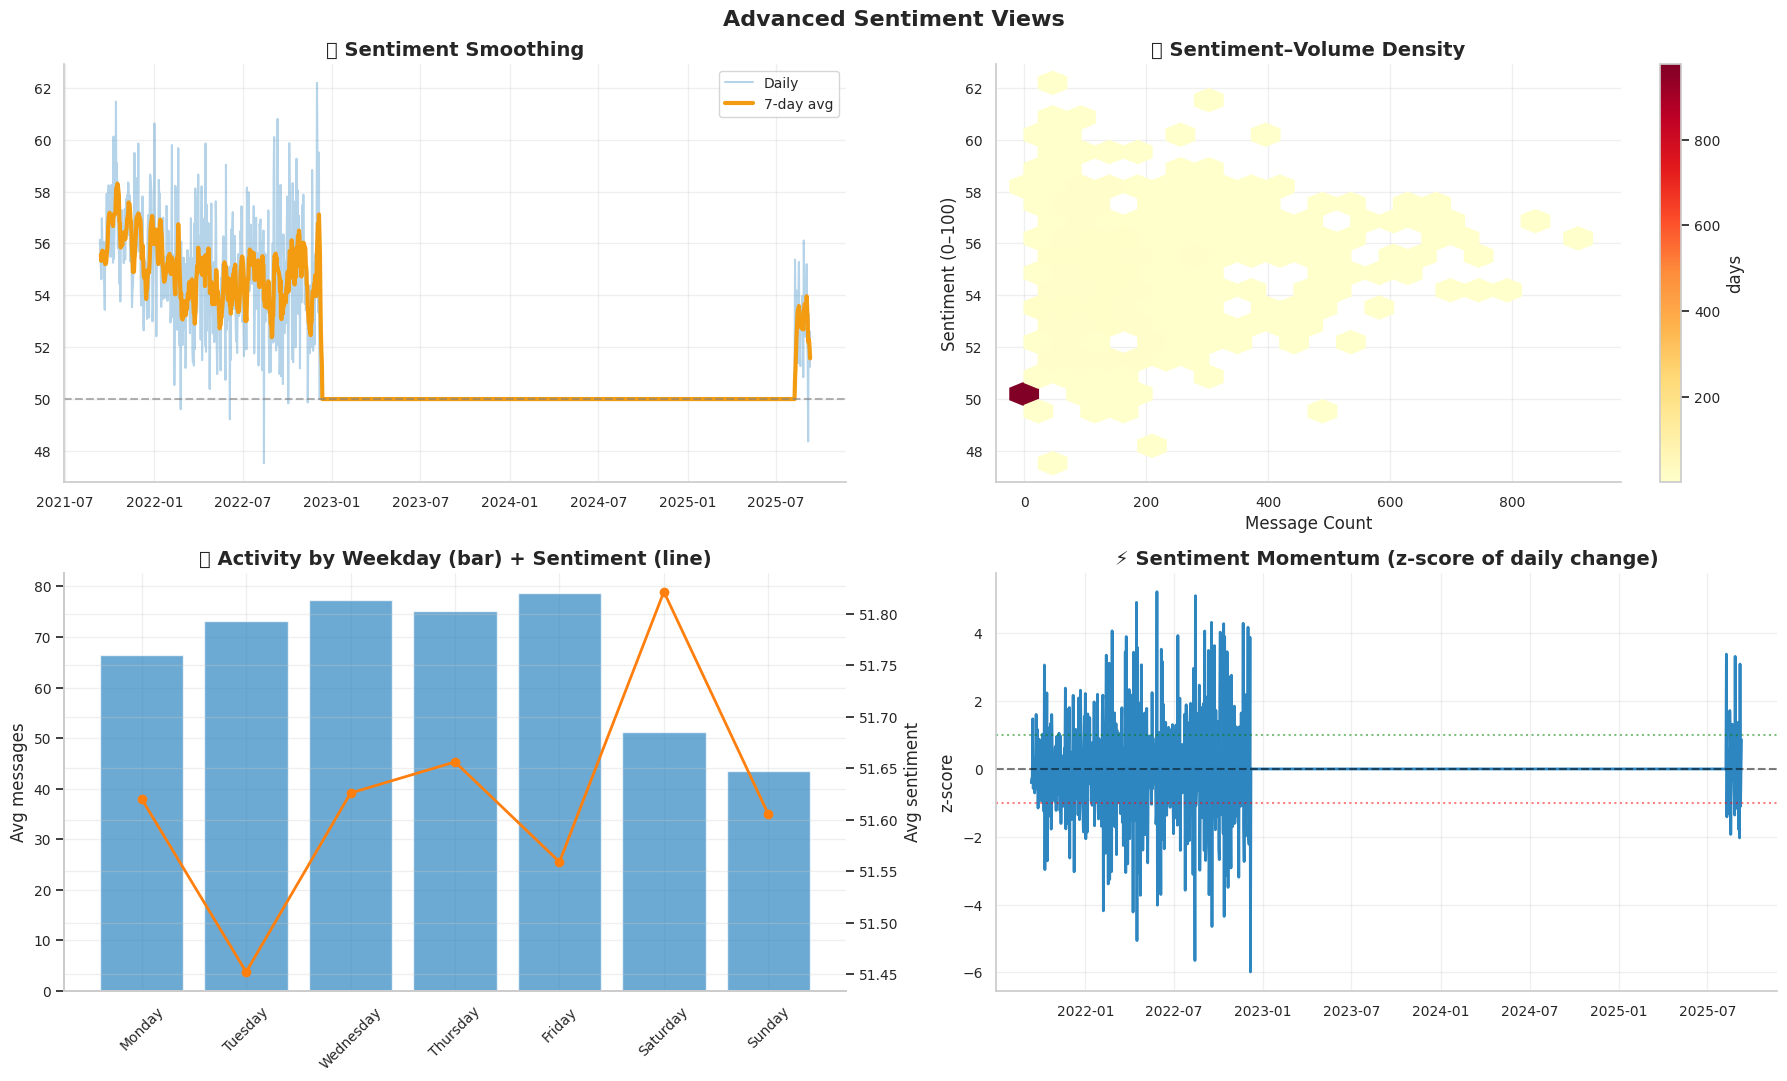

In [7]:
if not df.empty and len(df) > 3:
    import numpy as np
    import matplotlib.pyplot as plt

    d = df.sort_values('date').copy()

    # Per-source smoothing (7d)
    if 'source' in d.columns:
        d['avg_7d'] = d.groupby('source')['avg_score'].transform(lambda s: s.rolling(7, min_periods=3).mean())
    else:
        d['avg_7d'] = d['avg_score'].rolling(7, min_periods=3).mean()

    fig, axes = plt.subplots(2, 2, figsize=(18, 11))
    fig.suptitle('Advanced Sentiment Views', fontsize=16, fontweight='bold')

    # 1) Sentiment smoothing
    axes[0, 0].plot(d['date'], d['avg_score'], alpha=0.35, label='Daily')
    axes[0, 0].plot(d['date'], d['avg_7d'], linewidth=3, label='7-day avg')
    axes[0, 0].axhline(50, ls='--', c='gray', alpha=0.6)
    axes[0, 0].set_title('📈 Sentiment Smoothing', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2) Sentiment–volume density (hexbin)
    hb = axes[0, 1].hexbin(d['count'], d['avg_score'], gridsize=20, cmap='YlOrRd', mincnt=1)
    axes[0, 1].set_title('🔥 Sentiment–Volume Density', fontweight='bold')
    axes[0, 1].set_xlabel('Message Count')
    axes[0, 1].set_ylabel('Sentiment (0–100)')
    cb = plt.colorbar(hb, ax=axes[0, 1]); cb.set_label('days')

    # 3) Activity by weekday with sentiment overlay
    d['weekday'] = d['date'].dt.day_name()
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    gp = d.groupby('weekday').agg(avg_msgs=('count', 'mean'), avg_sent=('avg_score', 'mean')).reindex(order)
    axes[1, 0].bar(gp.index, gp['avg_msgs'], alpha=0.7)
    ax2 = axes[1, 0].twinx()
    ax2.plot(gp.index, gp['avg_sent'], marker='o', linewidth=2, color='tab:orange', label='Avg sentiment')
    axes[1, 0].set_title('📅 Activity by Weekday (bar) + Sentiment (line)', fontweight='bold')
    axes[1, 0].set_ylabel('Avg messages'); ax2.set_ylabel('Avg sentiment')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4) Momentum oscillator (z-score of daily change)
    d['change'] = d['avg_score'].diff()
    mean, std = d['change'].mean(), d['change'].std(ddof=0) or 1.0
    z = (d['change'] - mean) / std
    axes[1, 1].plot(d['date'], z, linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(1, color='green', linestyle=':', alpha=0.5)
    axes[1, 1].axhline(-1, color='red', linestyle=':', alpha=0.5)
    axes[1, 1].set_title('⚡ Sentiment Momentum (z-score of daily change)', fontweight='bold')
    axes[1, 1].set_ylabel('z-score')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## 🎯 Quick Analysis Functions

Run different time periods quickly:

In [ ]:
def quick_analysis(days):
    """Run quick analysis for specified days"""
    print(f'🚀 Quick {days}-day analysis...')
    records = run_simple_analysis(days_back=days)
    df = load_and_prepare_data()
    
    if not df.empty:
        avg_sentiment = df['avg_score'].mean()
        total_msgs = df['count'].sum()
        
        print(f'📊 Average Sentiment: {avg_sentiment:.1f}/100')
        print(f'💬 Total Messages: {total_msgs:,}')
        
        # Quick visualization
        plt.figure(figsize=(12, 4))
        plt.plot(df['date'], df['avg_score'], marker='o', linewidth=2)
        plt.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
        plt.title(f'📈 {days}-Day Sentiment Overview')
        plt.ylabel('Sentiment Score')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print('❌ No data available')

quick_analysis(1)   # Yesterday
quick_analysis(3)   # Last 3 days  
quick_analysis(14)  # Last 2 weeks